# Sistem Penilaian Esai Otomatis (SIMPLE-O) untuk Ujian Bahasa Indonesia dengan Siamese Manhattan Long Short-Term Memory
oleh Akmal Ramadhan Arifin

Sistem Penilaian Esai Otomatis (SIMPLE-O) ini dirancang untuk melakukan penilaian ujian esai Bahasa Indonesia. Jawaban mahasiswa akan dibandingkan dengan jawaban dosen untuk diprediksi nilai kesamaan atau kecocokannya. Proses training Word2Vec dilakukan terlebih dahulu untuk menghasilkan vektor berukuran n-dimensi. Selanjutnya, hasil dari training Word2Vec tersebut digunakan sebagai bobot pada layer embedding Keras. Kemudian hasil dari embedding akan menjadikan setiap kata pada esai menjadi angka dengan n-dimensi. Lalu, tiap esai akan di-training dengan Long Short-Term Memory yang sama dan menghasilkan output berukuran 50 dimensi. Jawaban mahasiswa dan dosen akan diukur kemiripannya dengan similarity function.

## Bagian 1: Pengambilan dan Preprocess Dataset

In [ ]:
import numpy as np
import pandas as pd
!pip install docx2txt
import docx2txt
import re
import os
import gensim
!pip install stop_words
from stop_words import get_stop_words
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
import keras.backend as K
from keras.optimizers import RMSprop,Adam,SGD,Adamax,Adadelta
from keras.regularizers import l2
from keras.metrics import RootMeanSquaredError

  Created wheel for docx2txt: filename=docx2txt-0.8-cp36-none-any.whl size=3963 sha256=f7d8b6cc564fb1094d5255288bc91e5a60073d86cf4d7cc98198e572c3222670
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
Successfully built docx2txt
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=7a2036a622ec30e5202b837032141111c057784e6a8e252d3332f0b2a0cbbe73
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


Using TensorFlow backend.


In [ ]:
#Ubah direktori sesuai lokasi penyimpanan dataset
DIR_DATA_MHS = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Dataset/jawaban_mahasiswa/'
DIR_DATA_DSN = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Dataset/jawaban_dosen/'
DIR_DATA_FORM = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Dataset/dataset2.csv'
DIR_HUMAN_RATER_4 = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Dataset/human_rater4.csv'
DIR_W2V_MODELS = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Dataset/word2vec_models/'

In [ ]:
stop_words = get_stop_words('indonesian')
def preprocess(text):
  text = re.sub("[^A-Za-z0-9]", " ", text)
  text = re.sub("^[0-9]", " ", text)
  words = text.lower().split()
  words = " ".join([str(word) for word in words if not word in stop_words])
  return words

def get_data(size=36):
  files = []  

  for i in range(1,5):
    name = DIR_DATA_DSN+'jwb'+str(i)+'.docx'
    files.append(name)

  for i in range(1,5):
    name = DIR_DATA_DSN+'jwbdosen'+str(i)+'.docx'
    files.append(name)
  
  for i in range(1,size):
    name = DIR_DATA_MHS+'Mahasiswa'+str(i)+'.docx'
    files.append(name)

  documents = []
  for i in range(len(files)):
    text = docx2txt.process(files[i])
    text = text.splitlines()
    text = [x for x in text if x]
    documents.append(text)
    
  fullDocs = [documents[i][x] for i in range(len(documents)) for x in range(len(documents[i]))]

  finalText = []
  for doc in fullDocs:
    text = preprocess(doc)
    finalText.append(text)
  
  return finalText

In [ ]:
data = get_data()
print(len(data))

148


In [ ]:
X_right_train = data[:4]*35
X_right_train2 = data[4:8]*35
X_left_train = data[8:]
print(len(X_right_train))
print(len(X_left_train))

140
140


In [ ]:
y_df = pd.read_csv(DIR_HUMAN_RATER_4)
human_rater = y_df['nilai']
human_rater = human_rater.to_numpy()
Y = human_rater.copy()
Y_train1 = Y/100
Y_train2 = Y.copy()

print(Y_train1[:10])
print(len(Y_train1))
print(Y_train2[:10])
print(len(Y_train2))

[0.9 0.8 1.  1.  0.9 0.8 1.  1.  0.9 0.8]
140
[ 90  80 100 100  90  80 100 100  90  80]
140


In [ ]:
testdf = pd.read_csv(DIR_DATA_FORM)
X_test = testdf['jawaban'].values
Y_test = testdf['nilai'].values
X_left_test = [preprocess(x) for x in X_test]
X_right_test = data[:4]*20
X_right_test2 = data[4:8]*20
Y_test1 = Y_test/100

print(len(X_left_test))
print(X_left_test[0:5])
print(Y_test[0:5])
print(Y_test1[0:5])

80
['komputer besar menggunakan unit kontrol unit penghitung unit memori untuk input mengeluarkan output', 'kondisi mematikan daya komputer menyimpan kondisi hibernate state', 'client pengguna server pusat punya sistem', 'fitur untuk meningkatkan performa sistem penggunaan mendekati peggunaan maksimal', 'dasar perkembangan komputer bagian seperi alu memori io']
[70 50 40 60 40]
[0.7 0.5 0.4 0.6 0.4]


In [ ]:
data.extend(X_left_test)
print(len(data))

228


## Bagian 2: Konversi Teks

In [ ]:
vocab = {}
i = 1
for answer in data:
  for token in answer.split():
    if token not in vocab:
      vocab[token] = i
      i += 1

print(len(vocab))
print(vocab)

1061
{'komputer': 1, 'model': 2, 'von': 3, 'neumann': 4, 'arsitektur': 5, 'dideskripsikan': 6, 'john': 7, 'tahun': 8, '1945': 9, 'first': 10, 'draft': 11, 'of': 12, 'a': 13, 'report': 14, 'on': 15, 'the': 16, 'edvac': 17, 'dijadikan': 18, 'basis': 19, 'unit': 20, 'pemrosesan': 21, 'berisi': 22, 'alu': 23, 'register': 24, 'prosesor': 25, 'kontrol': 26, 'instruction': 27, 'program': 28, 'counter': 29, 'memori': 30, 'untuk': 31, 'menyimpan': 32, 'data': 33, 'instruksi': 34, 'penyimpanan': 35, 'eksternal': 36, 'mekanisme': 37, 'input': 38, 'output': 39, 'hibernate': 40, 'pc': 41, 'fitur': 42, 'mematikan': 43, 'waktu': 44, 'sleep': 45, 'menggunakan': 46, 'tenaga': 47, 'menjaga': 48, 'tetap': 49, 'menyala': 50, 'proses': 51, 'berjalan': 52, 'secondary': 53, 'memory': 54, 'menyimpannya': 55, 'ram': 56, 'mengalami': 57, 'hilang': 58, 'dinyalakan': 59, 'ulang': 60, 'awal': 61, 'berbeda': 62, 'melanjutkan': 63, 'dimatikan': 64, 'kehilangan': 65, 'mati': 66, 'kekurangan': 67, 'jumlah': 68, 'dibut

In [ ]:
len_data = []
len_data = [len(x.split()) for x in data]
print(np.mean(len_data))
print(np.min(len_data))
print(np.max(len_data))
print(np.percentile(len_data, 98))

27.728070175438596
2
104
80.92000000000002


In [ ]:
max_features = 1100
max_len = 80

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data)

list_right_train = tokenizer.texts_to_sequences(X_right_train)
list_right_train2 = tokenizer.texts_to_sequences(X_right_train2)
list_left_train = tokenizer.texts_to_sequences(X_left_train)
list_right_test = tokenizer.texts_to_sequences(X_right_test)
list_right_test2 = tokenizer.texts_to_sequences(X_right_test2)
list_left_test = tokenizer.texts_to_sequences(X_left_test)

X_r_t = pad_sequences(list_right_train, maxlen=max_len, padding='post', truncating='post')
X_r_t2 = pad_sequences(list_right_train2, maxlen=max_len, padding='post', truncating='post')
X_l_t = pad_sequences(list_left_train, maxlen=max_len, padding='post', truncating='post')
X_r_te = pad_sequences(list_right_test, maxlen=max_len, padding='post', truncating='post')
X_r_te2 = pad_sequences(list_right_test2, maxlen=max_len, padding='post', truncating='post')
X_l_te = pad_sequences(list_left_test, maxlen=max_len, padding='post', truncating='post')

In [ ]:
print(X_r_t[0])
print(X_l_t[0])
print(X_r_te[0])
print(X_l_te[0])

[  1  21  12  13  21  25 540 148  12  13 203 288 541 542 543 544 545 289
 290 546  21  25 291 547   1   9 204 205  22 182  46   9  75 205 292 182
  14 378  20   4  37   2 105  63 548 245  16  18   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
[ 12 306  25   1 565 566  20  16  18  29 107  22   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
[  1  21  12  13  21  25 540 148  12  13 203 288 541 542 543 544 545 289
 290 546  21  25 291 547   1   9 204 205  22 182  46   9  75 205 292 182
  14 378  20   4  37   2 105  63 548 245  16  18   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
[  1  78  53   9  75  

In [ ]:
w2v_model = DIR_W2V_MODELS+'idwiki_word2vec_200.model'
id_w2v = gensim.models.Word2Vec.load(w2v_model)
print(id_w2v.wv.most_similar('komputer'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('perangkat', 0.675995409488678), ('laptop', 0.6660703420639038), ('komputasi', 0.6628507375717163), ('mikroprosesor', 0.6442168951034546), ('aplikasi', 0.6268411874771118), ('mainframe', 0.6198387742042542), ('cpu', 0.6057302951812744), ('nirkabel', 0.6046115756034851), ('peranti', 0.600152850151062), ('mikrokomputer', 0.5988426804542542)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
!pip install PySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

     |████████████████████████████████| 215kB 2.9MB/s 


In [ ]:
idx2word_set = set(id_w2v.wv.index2word)

In [ ]:
embed_size = 200

total_known_words = 0
total_unknown_words = 0
dict_known_words = {}
dict_unknown_words = {}

word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_features,embed_size))
unknown_vector = np.zeros((embed_size,))-1

In [ ]:
for word,idx in word_index.items():
  w = word
  if w in idx2word_set:
    embedding_matrix[idx] = id_w2v[w]    
    total_known_words += 1
    continue
  
  w = stemmer.stem(w)
  if w in idx2word_set:
    embedding_matrix[idx] = id_w2v[w]    
    total_known_words += 1
    continue
  
  embedding_matrix[idx] = unknown_vector
print(total_known_words)

992


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


## Bagian 3: Training Model

In [ ]:
def manhattan_distance(left,right):
  return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def get_model():
  input_left = Input(shape=(max_len,), dtype='int32')
  input_right = Input(shape=(max_len,), dtype='int32')
  embedding = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=max_len)  
  encoded_left = embedding(input_left)
  encoded_right = embedding(input_right)
  bilstm = LSTM(50, return_sequences=True,kernel_regularizer=l2(0.01))
  left_bi = bilstm(encoded_left)
  right_bi = bilstm(encoded_right)
  siamese_lstm = Bidirectional(LSTM(50, kernel_regularizer=l2(0.01)))
  left_output = siamese_lstm(left_bi)
  right_output = siamese_lstm(right_bi)  
  malstm_distance = Lambda(function=lambda x: manhattan_distance(x[0],x[1]), output_shape=lambda x:(x[0][0], 1))([left_output,right_output])  
  model = Model([input_left, input_right], [malstm_distance])  
  optimizer = Adam(learning_rate=0.001)  
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae',RootMeanSquaredError(name='rmse')])
  return model

In [ ]:
model = get_model()
model_trained = model.fit([X_l_t,X_r_t],Y_train1,batch_size=32,epochs=25,validation_data=([X_l_te,X_r_te],Y_test1))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140 samples, validate on 80 samples
Epoch 1/25
140/140 [==============================] - 5s 33ms/step - loss: 4.1657 - mae: 0.7749 - rmse: 0.8020 - val_loss: 3.6155 - val_mae: 0.4765 - val_rmse: 0.5326
Epoch 2/25
140/140 [==============================] - 1s 10ms/step - loss: 3.7238 - mae: 0.6591 - rmse: 0.6981 - val_loss: 3.2621 - val_mae: 0.3850 - val_rmse: 0.4485
Epoch 3/25
140/140 [==============================] - 1s 10ms/step - loss: 3.3152 - mae: 0.5299 - rmse: 0.5820 - val_loss: 2.9555 - val_mae: 0.3001 - val_rmse: 0.3697
Epoch 4/25
140/140 [==============================] - 1s 10ms/step - loss: 2.9694 - mae: 0.4150 - rmse: 0.4781 - val_loss: 2.6910 - val_mae: 0.2461 - val_rmse: 0.3108
Epoch 5/25
140/140 [==============================] - 1s 10ms/step - loss: 2.6768 - mae: 0.3293 - rmse: 0.3949 - val_loss: 2.4555 - val_mae: 0.2030 - val_rmse: 0.2698
Epoch 6/25
140/140 [==============================] - 1s 10ms/step - loss: 2.4252 - mae: 0.2684 - rmse: 0.3346 - val_los

In [ ]:
import matplotlib.pyplot as plt

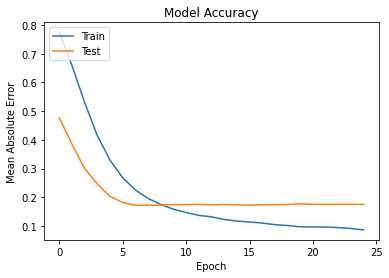

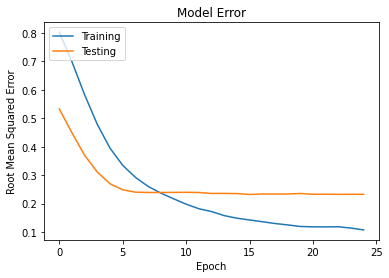

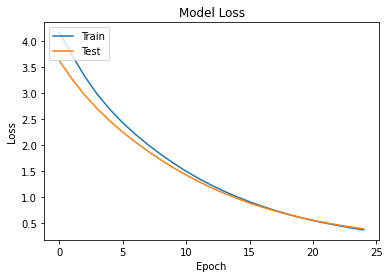

In [ ]:
plt.plot(model_trained.history['mae'])
plt.plot(model_trained.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(model_trained.history['rmse'])
plt.plot(model_trained.history['val_rmse'])
plt.title('Model Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

plt.plot(model_trained.history['loss'])
plt.plot(model_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def get_scores(y_test,output,scale):
  test_human_rater = []
  test_scores = []
  collect = []
  collect_s = []
  count = 0
  for i in range(len(y_test)):
    count += 1
    collect_s.append(output[i])
    collect.append(y_test[i])
    if count % 4 == 0:
      score = np.mean(collect)    
      score_s = np.round(np.mean(collect_s)*scale)
      test_human_rater.append(score)
      test_scores.append(score_s)
      collect = []
      collect_s = []

  dataf = {'Human Rater':test_human_rater, 'Model':test_scores}
  table = pd.DataFrame(dataf)
  return table

In [ ]:
model_output = model.predict([X_l_te, X_r_te])
model1_scores = get_scores(Y_test,model_output,100)
print(model1_scores)

    Human Rater  Model
0          55.0   69.0
1          50.0   67.0
2          47.5   66.0
3          52.5   77.0
4          80.0   72.0
5          35.0   70.0
6          50.0   71.0
7          52.5   63.0
8          27.5   46.0
9          77.5   84.0
10         17.5   45.0
11         75.0   67.0
12         62.5   73.0
13         35.0   48.0
14         92.5   74.0
15         75.0   79.0
16         65.0   73.0
17         67.5   71.0
18         82.5   88.0
19         82.5   79.0


In [ ]:
model1_train_output = model.predict([X_l_t, X_r_t])
model1_train_scores = get_scores(Y,model1_train_output,100)
print(model1_train_scores)

    Human Rater  Model
0         92.50   92.0
1         92.50   94.0
2         77.50   80.0
3         89.75   86.0
4         87.50   86.0
5         97.50   96.0
6         90.00   91.0
7         90.00   92.0
8         85.00   89.0
9         77.50   76.0
10        85.00   84.0
11        67.50   70.0
12        92.50   92.0
13        92.50   91.0
14        87.50   86.0
15        95.00   93.0
16        92.50   94.0
17        77.50   83.0
18        87.50   87.0
19        95.00   93.0
20        92.50   88.0
21        80.00   79.0
22        82.50   87.0
23        77.50   79.0
24        80.00   79.0
25        82.50   79.0
26        80.00   78.0
27        75.00   72.0
28        90.00   89.0
29        75.00   75.0
30        50.00   54.0
31        87.50   87.0
32        80.00   78.0
33        87.50   89.0
34        90.00   91.0


In [ ]:
def export_csv(score,output,fname):
  f = '/content/drive/My Drive/KP-SEMINAR-SKRIPSI/SKRIPSI/Program/Output/baru/'+fname
  tab = {'true':score,'prediction':output}
  dft = pd.DataFrame(tab)
  dft.to_csv(f,index=False,header=True)

In [ ]:
export_csv(Y_test1,model_output.flatten(),'skenario6_testing_32_75.csv')
export_csv(Y_train1,model1_train_output.flatten(),'skenario6_training_32_75.csv')
# export_csv(Y_test1,model2_output.flatten(),'skenario4_testing_tanpaw2v.csv')
# export_csv(Y_train1,model2_train_output.flatten(),'skenario4_training_tanpaw2v.csv')